In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from mtcnn import MTCNN
import cv2

import os
import re

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertModel

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


c:\Users\gsevr\cudaenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('MELD.Raw/dev_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")
df = df.sample(frac=0.02,ignore_index=True)
split_size = int(len(df) * 0.8)

In [3]:
face_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet") #include_top=True for predictions, False for embeddings


The following produces detector embeddings without the use of a NN model.

In [4]:
detector = MTCNN()

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                for face in detector.detect_faces(frame):
                    x, y, w, h = face['box']
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = np.squeeze(single_video_embeddings)
        else:
            one_face_videos[file_name] = 'too many faces'


1/1 [==============================] - 0s 108ms/step


c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


In [5]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [tf.constant(value).shape for value in one_face_videos.values()]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (2,224,224,3))]


c:\Users\gsevr\cudaenv\Lib\site-packages\pandas\core\ops\array_ops.py:131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                 .strip() for txt in df['Utterance']]

In [7]:
ohe = OneHotEncoder(categories=[df.Emotion.unique()])
labels = ohe.fit_transform(df.Emotion.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [8]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]

The following uses detector embeddings to fine tune the VGG16 model

In [9]:
#this includes transfer learning for vgg16. Switch the top layers to something appropriate. it works tho

for layer in face_model.layers:
    layer.trainable=True

base = face_model.output

flat = Flatten(name="flatten")(base)
fc = (Dense(256, activation='relu'))(flat)
fc_two = (Dense(64, activation='relu'))(fc)
output = (Dense(len(df.Emotion.unique()), activation='softmax'))(fc_two)
vid_pred_model = Model(inputs=face_model.input,outputs=output)

vid_pred_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

vid_train_data = []
for video in [value for value in one_face_videos.values() if tf.constant(value).shape == (2,224,224,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=5, validation_data=(vid_val,labels_val))

Epoch 1/5


c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 24s 24s/step - loss: 1.7309 - accuracy: 0.3529 - val_loss: 7.2981 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 24s 24s/step - loss: 4.9117 - accuracy: 0.2941 - val_loss: 1.7511 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 24s 24s/step - loss: 1.4947 - accuracy: 0.1765 - val_loss: 2.7665 - val_accuracy: 0.6667
Epoch 4/5
1/1 [==============================] - 24s 24s/step - loss: 1.9535 - accuracy: 0.3529 - val_loss: 2.9027 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 24s 24s/step - loss: 1.4856 - accuracy: 0.2941 - val_loss: 2.4661 - val_accuracy: 0.0000e+00


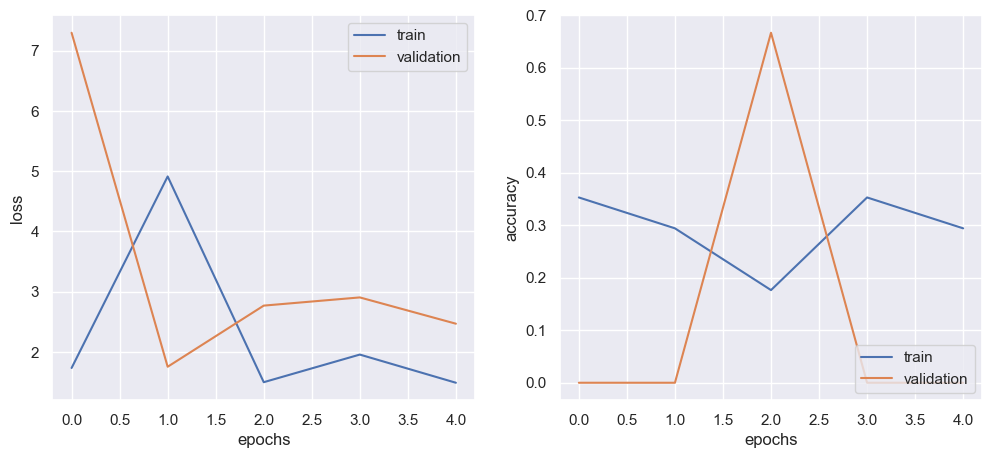

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'])
plt.plot(history_vid_pred.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'])
plt.plot(history_vid_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [11]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)
video_predictions

1/1 [==============================] - 2s 2s/step


array([[0.25168955, 0.24819766, 0.23636593, 0.25377578, 0.00997111],
       [0.25456843, 0.24850953, 0.23483251, 0.25217178, 0.00991772],
       [0.2561351 , 0.24871884, 0.23345758, 0.25110564, 0.01058281]],
      dtype=float32)

In [12]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-4]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)


        face_embedding = video_embedding_model.predict(preprocessed_face) 
        face_embeddings.append(np.squeeze(face_embedding))
        
        return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                for face in detector.detect_faces(frame):
                    x, y, w, h = face['box']
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = np.squeeze(single_video_embeddings)
        else:
            video_embeddings[file_name] = 'too many faces'


1/1 [==============================] - 0s 65ms/step


In [14]:
#THIS GETS PREDICTIONS

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
token_type_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

bert_outputs = model(
    input_ids=input_ids,
    token_type_ids=token_type_ids,
    attention_mask=attention_mask
)

pooled_output = bert_outputs.pooler_output
dense_layer = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
less_dense = tf.keras.layers.Dense(64, activation='relu')(dense_layer)
output_layer = tf.keras.layers.Dense(len(df.Emotion.unique()), activation='softmax')(less_dense)


text_pred_model = tf.keras.Model(
    inputs=[input_ids, token_type_ids, attention_mask],
    outputs=output_layer
)


# Data and labels
train_texts = list(df_train.prepro.values)
train_labels = list(labels_train)

val_texts = list(df_val.prepro.values)
val_labels = list(labels_val)

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)


# Split inputs
train_inputs = {
    'input_ids': np.array(train_encodings['input_ids']),
    'token_type_ids': np.array(train_encodings['token_type_ids']),
    'attention_mask': np.array(train_encodings['attention_mask'])
}

val_inputs = {
    'input_ids': np.array(val_encodings['input_ids']),
    'token_type_ids': np.array(val_encodings['token_type_ids']),
    'attention_mask': np.array(val_encodings['attention_mask'])
}

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_inputs,
    train_labels
)).shuffle(len(train_inputs)).batch(1,drop_remainder=True)  # Adjust batch size as needed. will return error if batch_size > len(train_inputs)

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_inputs,
    val_labels
)).shuffle(len(val_inputs)).batch(1,drop_remainder=True)


# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compiling
text_pred_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'], run_eagerly=True)

# Fine-tuning
history_text_pred = text_pred_model.fit(train_dataset, epochs=3, validation_data=(val_dataset))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
17/17 [==============================] - 77s 5s/step - loss: 1.6239 - accuracy: 0.1765 - val_loss: 1.8791 - val_accuracy: 0.0000e+00
Epoch 2/3
17/17 [==============================] - 77s 5s/step - loss: 1.3234 - accuracy: 0.4118 - val_loss: 1.3878 - val_accuracy: 0.6667
Epoch 3/3
17/17 [==============================] - 79s 5s/step - loss: 1.1230 - accuracy: 0.5882 - val_loss: 2.2782 - val_accuracy: 0.0000e+00


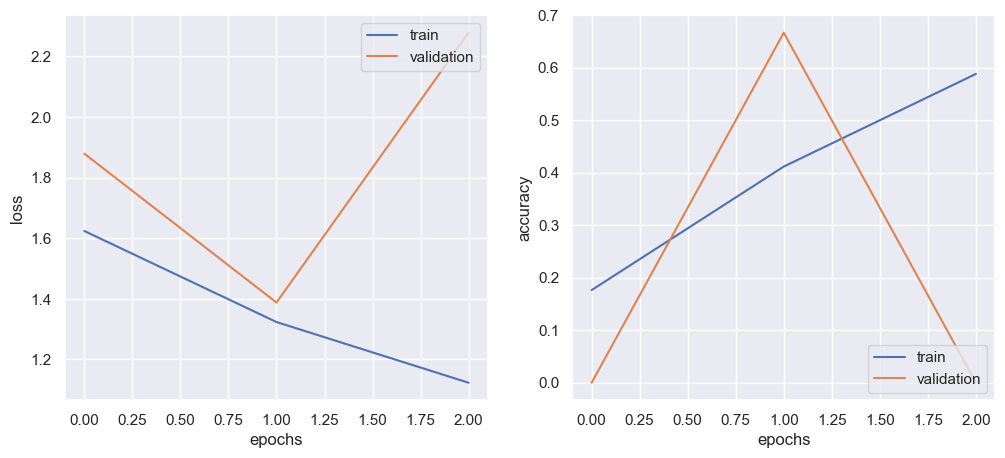

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_text_pred.history['loss'])
plt.plot(history_text_pred.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_text_pred.history['accuracy'])
plt.plot(history_text_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [16]:
#Prediction format

input_texts = df_val.Utterance.values 

input_encodings = tokenizer.batch_encode_plus(input_texts, truncation=True, padding='max_length', max_length=128, return_tensors="tf")

text_predictions = text_pred_model.predict({
    'input_ids': input_encodings['input_ids'],
    'token_type_ids': input_encodings['token_type_ids'],
    'attention_mask': input_encodings['attention_mask']
})

predicted_emotions = np.argmax(text_predictions, axis=1)

emotion_labels = df.Emotion.unique() 

predicted_emotion_labels = [emotion_labels[idx] for idx in predicted_emotions]

for text, label in zip(input_texts, predicted_emotion_labels):
    print(f"Text: {text}, Predicted emotion: {label}")



1/1 [==============================] - 2s 2s/step
Text: Okay, there's an herbal tea you can drink., Predicted emotion: anger
Text: Look at Emma!, Predicted emotion: neutral
Text: What are you gonna do?, Predicted emotion: anger


In [17]:
# THIS GETS EMBEDDINGS

text_embeddings_model = tf.keras.Model(inputs=text_pred_model.input, outputs=bert_outputs.last_hidden_state)

text_embeddings = text_embeddings_model.predict(val_inputs)



1/1 [==============================] - 1s 773ms/step


In [18]:
con_ten = []
video_embeddings_array = np.array([embedding for embedding in one_face_videos.values() if embedding != 'too many faces'])

for i in range(len(df)):
    con_ten.append(np.concatenate([text_embeddings.ravel(),video_embeddings_array.ravel()]))

df['concat'] = con_ten

C:\Users\gsevr\AppData\Local\Temp\ipykernel_16128\539865269.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  video_embeddings_array = np.array([embedding for embedding in one_face_videos.values() if embedding != 'too many faces'])


In [19]:
fusion_data = np.squeeze(np.array([con_ten]))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [20]:
# Model for early fusion

fusion_model = Sequential()


fusion_model.add(Dense(256, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(df.Emotion.unique()), activation='softmax'))

fusion_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=5,validation_data=(fusion_val,labels_val))

Epoch 1/5


c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 31s 31s/step - loss: 1.6338 - accuracy: 0.2353 - val_loss: 1034.4176 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 22s 22s/step - loss: 1038.4467 - accuracy: 0.4118 - val_loss: 1301.7733 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 22s 22s/step - loss: 1397.7373 - accuracy: 0.2353 - val_loss: 1240.0468 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 22s 22s/step - loss: 933.3701 - accuracy: 0.3529 - val_loss: 1266.1886 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 22s 22s/step - loss: 1818.8751 - accuracy: 0.1765 - val_loss: 1471.8322 - val_accuracy: 0.0000e+00


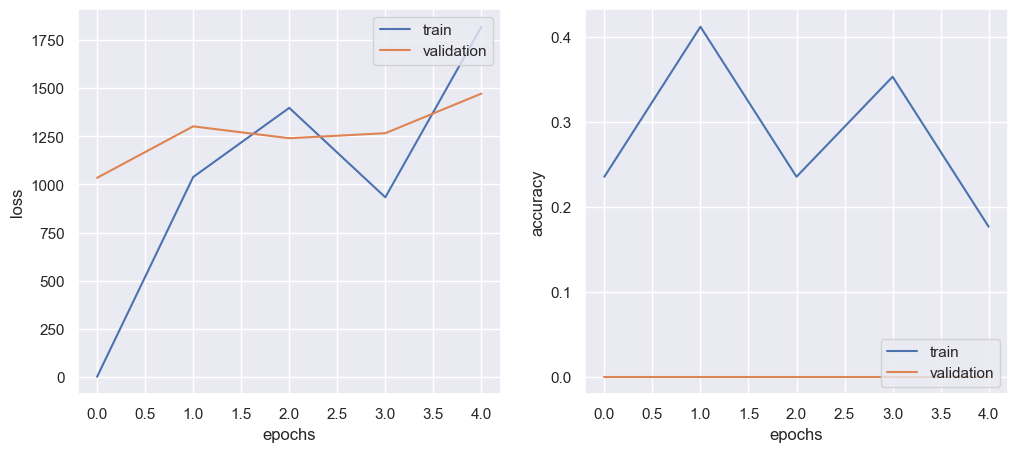

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fusion_model_history.history['loss'])
plt.plot(fusion_model_history.history['val_loss'])
# plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(fusion_model_history.history['accuracy'])
plt.plot(fusion_model_history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
# plt.xticks([i for i in range(0,20)])

plt.show()

In [25]:
fusion_model.predict(fusion_val)

c:\Users\gsevr\cudaenv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 3s 3s/step


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [23]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions, df):
    final_predictions = []

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = df.Emotion.unique()[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = df.Emotion.unique()[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = df.Emotion.unique()[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [24]:
late_fusion_predictions = final_preds(text_predictions, video_predictions, df)

#TODO Confusion matrix

Text: 0.36571136116981506, Visual: 0.25377577543258667
Text wins
Text: 0.35290616750717163, Visual: 0.2545684278011322
Text wins
Equal predictions


In [ ]:
correct_predictions = sum(p == t for p, t in zip(late_fusion_predictions, ))
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions